<b>Authors</b><br>
Xiaoxia Lin, Ekaterina Putintseva

----------------------------------------------------------------------------------------------------------------------

<b>Exercise 9</b><br><br>
Use a genetic algorithm to learn a strategy for a game known as
the prisoner's dilemma.<br>
-- Two members of a criminal gang are arrested and imprisoned.<br>
-- Each prisoner is in solitary confinement with no means of communicating
with the other.<br>
-- They hope to get both sentenced to a year in prison on a lesser charge.<br>
-- Simultaneously, the judge offers each prisoner a bargain: each prisoner is given the opportunity either to: betray the other by testifying that the other committed the crime, or to cooperate with the other by remaining silent.<br>
-- The offer is:
<img src="offer.png" style="width: 600px">

The prisoner's dilemma is to decide whether to betray or cooperate with the other prisoner.

<b>Solution</b><br><br>
To solve this problem using a genetic algorithm, we use a strategy of the player as one 'chromosome'. The game takes several rounds, each round the player's decision is based on the cumulated history of the other player's moves during the previous rounds.

In [12]:
import numpy as np
from matplotlib import pyplot as plt
import random
import itertools
import random
from collections import OrderedDict
from __future__ import division

%matplotlib inline

To code all the possible outcomes of the game, we create a list of all possible combinations of a certain size (that is equal to the number of rounds of the game). Then, we use this list as keys of the strategy dictionary, where the values are the decision our player should take.

In [13]:
def sq_size(n):
    size = 1
    for i in range(1, n+1):
        size += len([''.join(p) for p in itertools.product('01', repeat = i)])
    return size

In [14]:
def answer_generator(size):
    return ''.join(random.choice(['0', '1']) for _ in range(size))

We use this function to extract the strategy from the 'chromosome' and put it into the strategy dictionary. Thus, for example, if the length of the game is 2 rounds, the chromosome will consist of 3 values (each being 0s or 1s), corresponding to:<br>
1) the first move, which is not based on any history<br>
2) the second move:<br>
---> in case the first move of the opponent was 0<br>
---> in case the first move of the opponent was 1<br>

In [15]:
def extract_strategy(sq, size):
    perm_list = []
    for i in range(1, size+1):
        perm_list += [''.join(p) for p in itertools.product('01', repeat = i)]
    decision_dict = OrderedDict()
    for index in range(len(perm_list)):
        decision_dict[perm_list[index]] = sq[index + 1]
    return decision_dict

In [16]:
def evaluate(pl1, pl2):
    if pl1 == '0' and pl2 == '0':
        return 1
    if pl1 == '1' and pl2 == '0':
        return 0
    if pl1 == '0' and pl2 == '1':
        return 3
    if pl1 == '1' and pl2 == '1':
        return 6

As the method of selection, we are using the roulette wheel selection. Therefore, since the initial problem is to minimize the amount of years the player gets, it should be transformed into a maximization problem. Here, we subtract the score that a player gets in the end of one game from the maximum score that can be obtained (number of rounds multiplied by 6).<br><br>
Each game, the player is playing against a randomly generated <i>synthetic player</i>. In other words, against a randomly generated sequence of 0s and 1s of the length equal to the number of rounds in the game.

In [17]:
def score(sq, size):
    synthetic_player = answer_generator(size)
    decision_dict = extract_strategy(sq, size)
    score = 0
    answer = ''
    score += evaluate(sq[0], synthetic_player[0])
    answer += sq[0]
    for i in range(1, len(synthetic_player)):
        score += evaluate(decision_dict[synthetic_player[:i+1]], synthetic_player[i])
        answer += decision_dict[synthetic_player[:i+1]]
    score = 6*size - score
    return score

To account for many possible outcomes of the game, the fitness function constituted a normalized cumulative score that is collected across 100 games.

In [18]:
def cum_score(sq, size, rounds = 100):
    cum_score = 0
    for x in xrange(100):
        cum_score += score(sq, size)
    return cum_score/100

The crossover function is introduced here with the probability of a crossover constituting 50%. The 'chromosomes' to undergo the crossover as well as the point of crossover are selected randomly.

In [19]:
def crossover(sq_list, size):
    p = .5
    to_cross = []
    new_sq_list = []
    for sq in sq_list:
        x = random.random()
        if x <= p:
            to_cross.append(sq)
        else:
            new_sq_list.append(sq)
    if len(to_cross)%2 != 0:
        new_sq_list.append(to_cross[-1])
        to_cross.remove(to_cross[-1])
    for sq_id in range(0, len(to_cross), 2):
        x = int(np.random.randint(len(to_cross[sq_id]), size=1))
        new_sq_list.append(to_cross[sq_id][:x]+to_cross[sq_id+1][x:])
        new_sq_list.append(to_cross[sq_id+1][:x]+to_cross[sq_id][x:])
    return new_sq_list  

The mutation function is introduced here with the probability of a mutation constituting 1%.

In [20]:
def mutate(sq, p = 0.01):
    mutation = {'0':'1', '1':'0'}
    for i in range(len(sq)):
        x = random.random()
        if x <= p:
            sq = sq[:i] + mutation[sq[i]] + sq[i+1:]
    return sq

The probability of being selected is assigned according to the normalized cumulative score obtained.

In [21]:
def prob_assignment(sq_list, size):
    score_list = []
    max_score = 0
    for sq_id in range(len(sq_list)):
        score = cum_score(sq_list[sq_id], size)
        score_list.append(score)
        
        if score > max_score:
            max_score = score
            best_sq = sq_list[sq_id]
    
    F = sum([score_list[sq_id] for sq_id in range(len(sq_list))])
    selection_prob = []
    cum_selection_prob = []
    cum = [0, 0]
    for sq_id in range(len(sq_list)):
        selection_prob.append(score_list[sq_id]/F)
        cum[1] += selection_prob[sq_id]
        cum_selection_prob.append(list(cum))
        cum[0] += selection_prob[sq_id]
    
    return cum_selection_prob, F, max_score, best_sq

The selection process is performed according to the roulette wheel strategy.

In [22]:
def selection(sq_list, size):
    new_sq_list = []
    cum_selection_prob, F, max_score, best_sq = prob_assignment(sq_list, size)
    for sq_id in range(len(sq_list)):
        x = random.random()
        for sq_id in range(len(cum_selection_prob)):
            if cum_selection_prob[sq_id][0] <= x < cum_selection_prob[sq_id][1]:
                new_sq_list.append(sq_list[sq_id])
        if x == 1.:
            new_sq_list += [sq for sq in sq_list if cum_selection_prob[sq][1] == 0] 
    return new_sq_list, F, max_score, best_sq

A random list of 20 initial 'chromosomes' is generated here. The game length constitutes 10 rounds.

In [36]:
number_of_rounds = 10
sq_list = [answer_generator(sq_size(number_of_rounds)) for x in xrange(20)]

Over the course of 100 rounds of selection the cumulative score of the population, the maximum score of the iteration and the best strategy of the iteration are being recorded.

In [37]:
max_score_history = []
best_sq_history = []
F_cum = []

for x in xrange(100):
    sq_list_new, F, max_score, best_sq = selection(sq_list, number_of_rounds)
    F_cum.append(F)
    max_score_history.append(max_score)
    best_sq_history.append(best_sq)
    sq_list = list(sq_list_new)
    sq_list = crossover(sq_list, number_of_rounds)
    mutated = []
    for sq in sq_list:
        mutated.append(mutate(sq))
    sq_list = list(mutated)

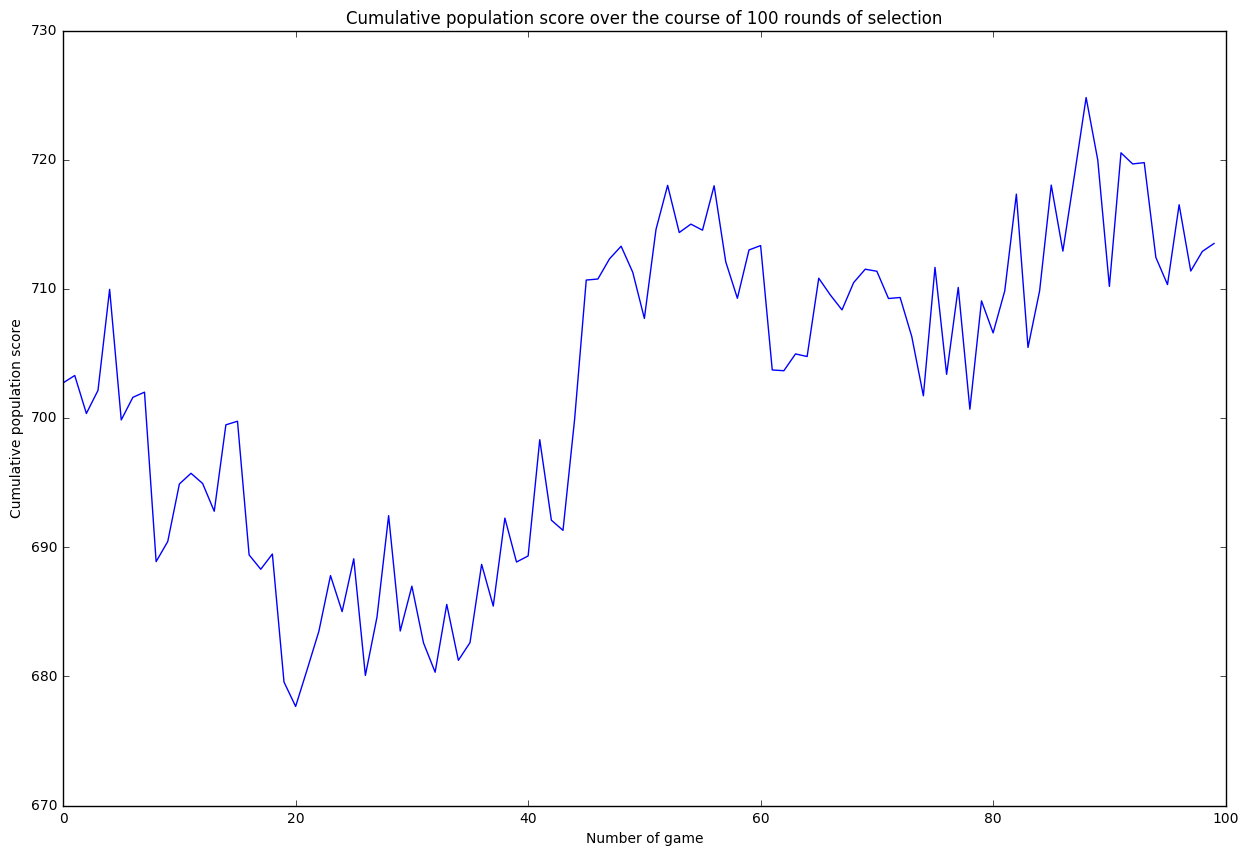

In [38]:
plt.figure(figsize=[15,10])
plt.plot(F_cum)
plt.xlabel('Number of game')
plt.ylabel('Cumulative population score')
plt.title('Cumulative population score over the course of 100 rounds of selection');

Extracting the best strategy evolved over the course of evolution (not necessarily being a part of the last rounds of selection):

In [35]:
for i in range(len(max_score_history)):
    if max_score_history[i] == max(max_score_history):
        index = i
        
extract_strategy(best_sq_history[index], number_of_rounds)

OrderedDict([('0', '0'),
             ('1', '1'),
             ('00', '1'),
             ('01', '0'),
             ('10', '1'),
             ('11', '0'),
             ('000', '1'),
             ('001', '1'),
             ('010', '1'),
             ('011', '0'),
             ('100', '0'),
             ('101', '0'),
             ('110', '1'),
             ('111', '1'),
             ('0000', '0'),
             ('0001', '0'),
             ('0010', '1'),
             ('0011', '1'),
             ('0100', '1'),
             ('0101', '0'),
             ('0110', '1'),
             ('0111', '0'),
             ('1000', '1'),
             ('1001', '0'),
             ('1010', '0'),
             ('1011', '0'),
             ('1100', '0'),
             ('1101', '0'),
             ('1110', '0'),
             ('1111', '1'),
             ('00000', '1'),
             ('00001', '1'),
             ('00010', '0'),
             ('00011', '0'),
             ('00100', '1'),
             ('00101', '0'),
        